<a href="https://colab.research.google.com/github/berkan-sahin/cs484/blob/master/cs484.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf cs484 && git clone https://github.com/berkan-sahin/cs484.git

Cloning into 'cs484'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 307 (delta 12), reused 15 (delta 5), pack-reused 282
Receiving objects: 100% (307/307), 83.51 MiB | 44.99 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!pip3 install -U torch torcheval torchvision seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
import time
import copy
import seaborn as sn





In [ ]:
class HockeyDataset(Dataset):

    def __init__(self, data_dir, transformer) -> None:
        self.data_dir = data_dir
        self.transformer = transformer

    def __len__(self):
        return 192

    def __getitem__(self, index) -> Tuple[any, any]:
        class_idx = index / 64
        if (class_idx < 1):
            class_name = 'freehit'
        elif (class_idx < 2):
            class_name = 'goal'
        elif (class_idx < 3):
            class_name = 'penaltycorner'
        else:
            class_name = 'penaltyshot'  # should never happen

        img_name = os.path.join(self.data_dir, class_name,
                                f'{(index % 64) + 1}.jpg')
        image = read_image(img_name).to(torch.float32)
        image = self.transformer(image)
        return image, class_idx


preprocess = transforms.Compose([
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.ToTensor(),
])

- modified the learning rate (from 0.0001 to 0.001)
- using pytorch's pretrained weights
- freezing the feature detection layers
- bugfixes
- batch size incremented to 32 from 4

Using device:  cuda:0
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)
Fold 0, epoch count: 29
Accuracy: 0.875
Precision: 0.875
Recall: 0.875
F1 Score: 0.875
Confusion matrix: [[ 9.  0.  0.]
 [ 2.  9.  0.]
 [ 0.  2. 10.]]
Loss: 0.3822697699069977


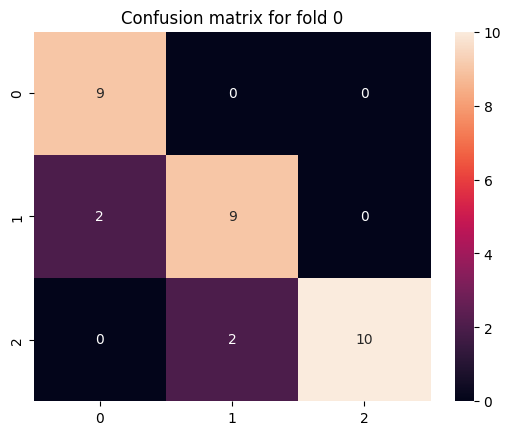

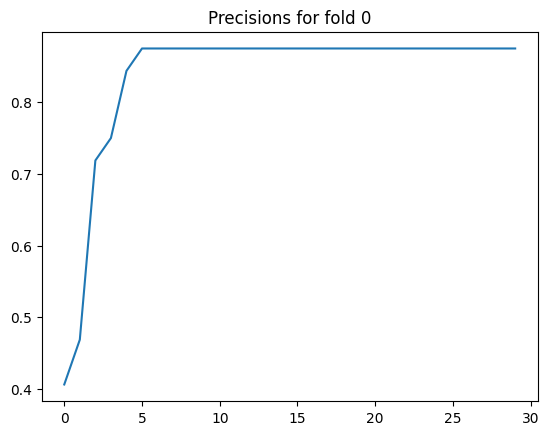

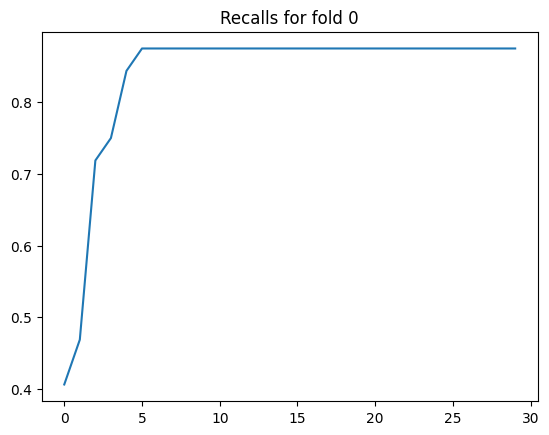

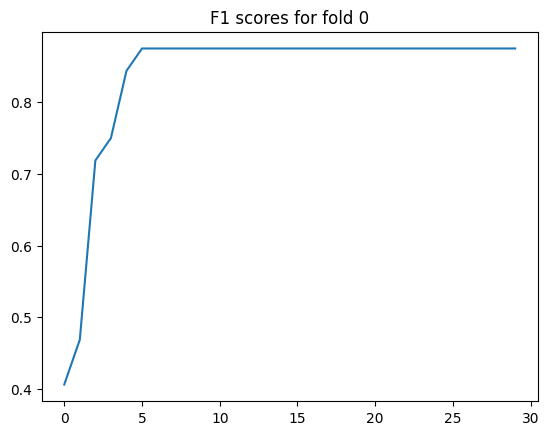

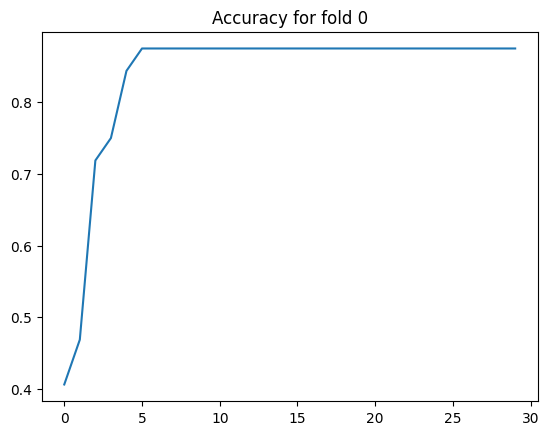

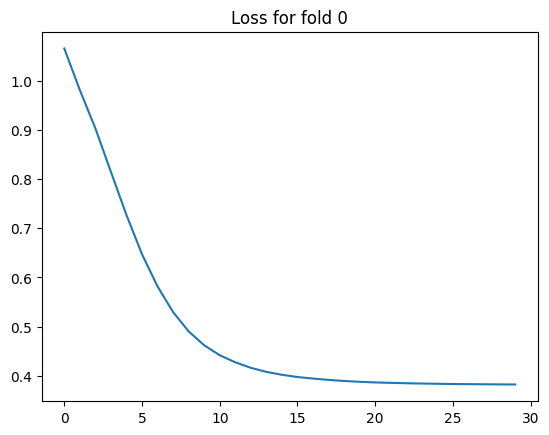

Fold 1, epoch count: 29
Accuracy: 0.96875
Precision: 0.96875
Recall: 0.96875
F1 Score: 0.96875
Confusion matrix: [[10.  0.  0.]
 [ 1. 11.  0.]
 [ 0.  0. 10.]]
Loss: 0.26902201771736145


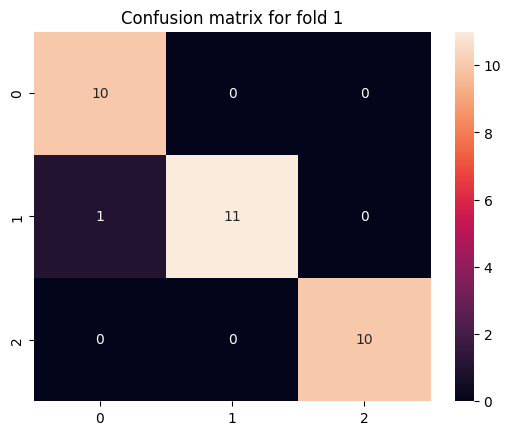

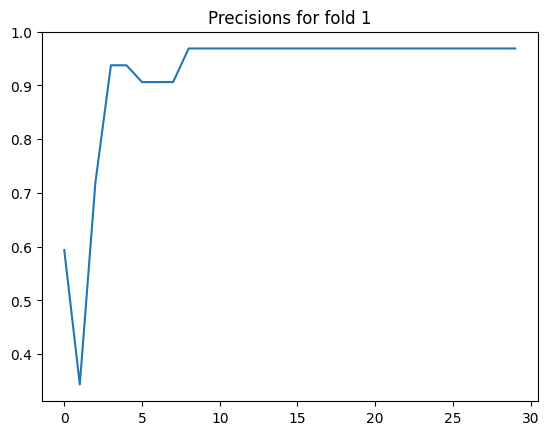

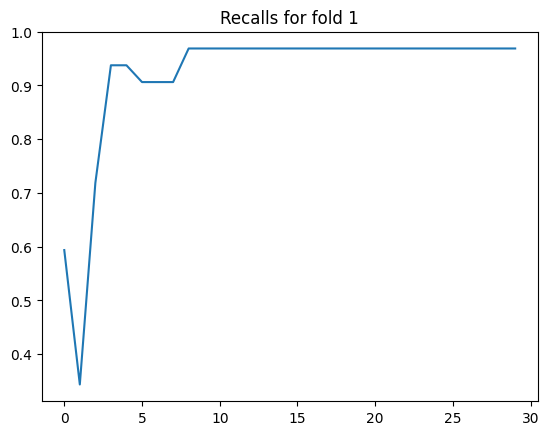

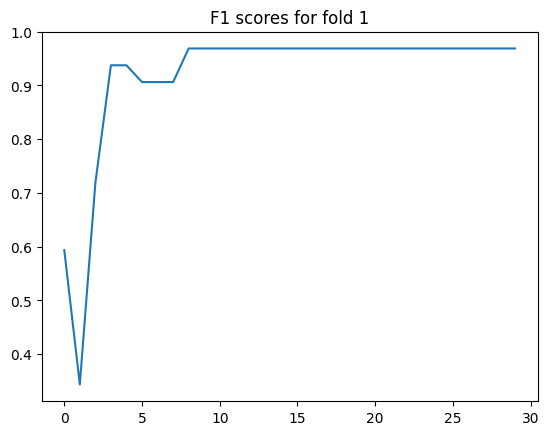

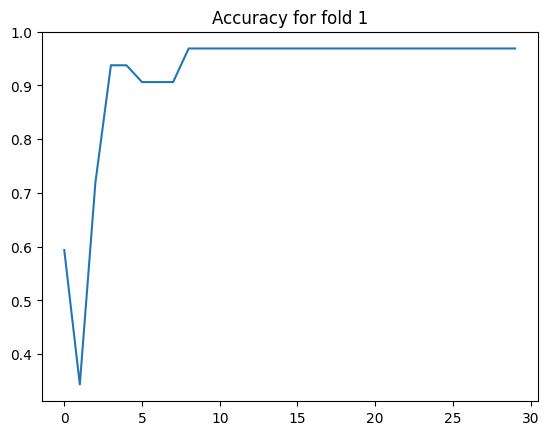

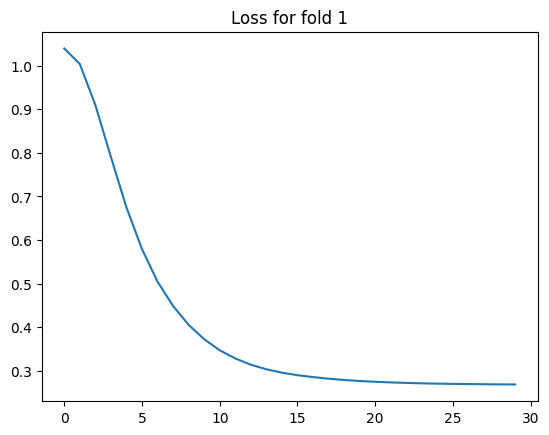

Fold 2, epoch count: 29
Accuracy: 0.875
Precision: 0.875
Recall: 0.875
F1 Score: 0.875
Confusion matrix: [[ 8.  1.  0.]
 [ 2.  9.  0.]
 [ 1.  0. 11.]]
Loss: 0.4642948508262634


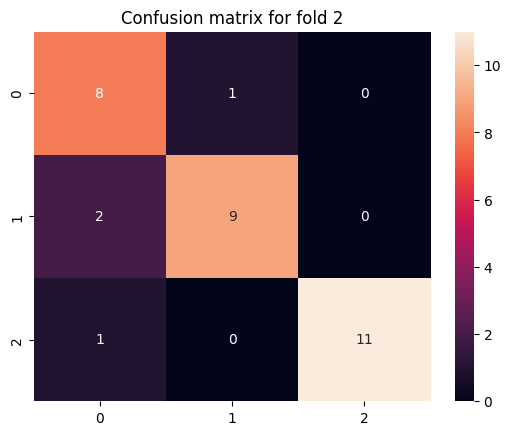

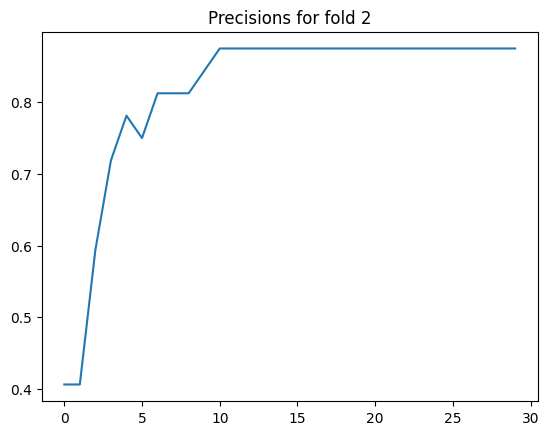

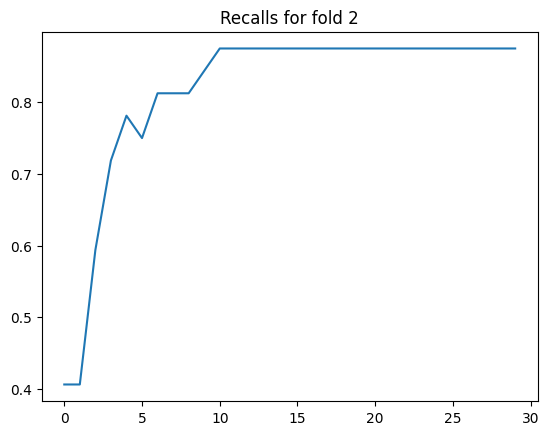

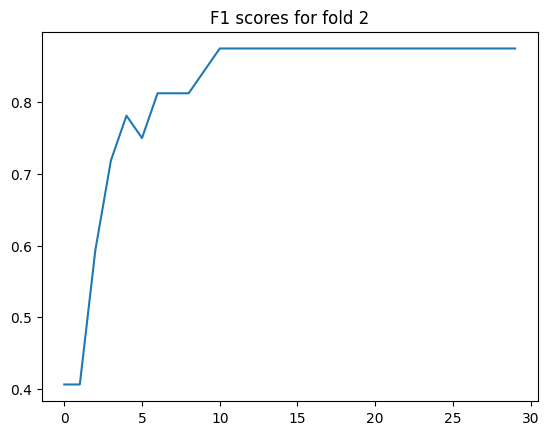

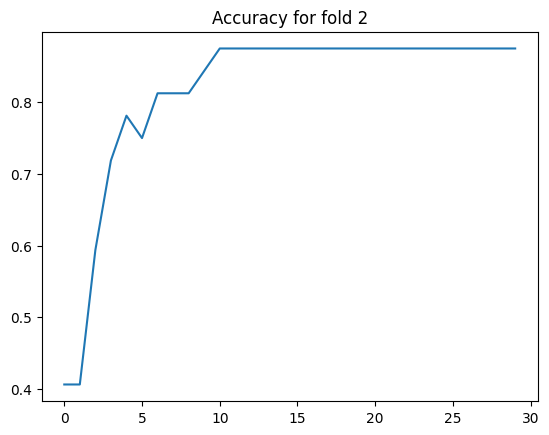

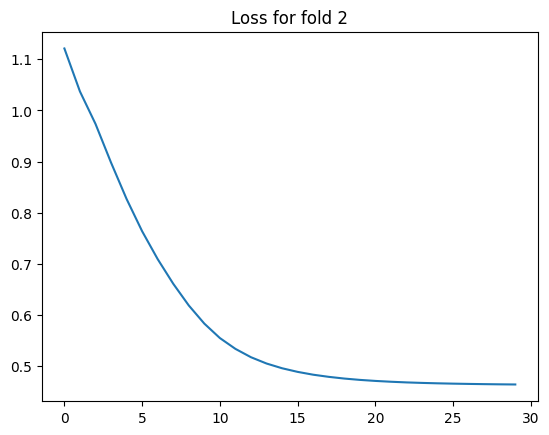

Fold 3, epoch count: 29
Accuracy: 0.90625
Precision: 0.90625
Recall: 0.90625
F1 Score: 0.90625
Confusion matrix: [[ 9.  0.  1.]
 [ 1. 10.  0.]
 [ 1.  0. 10.]]
Loss: 0.3594183623790741


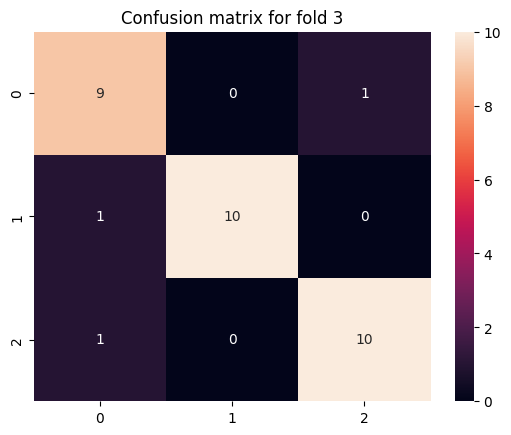

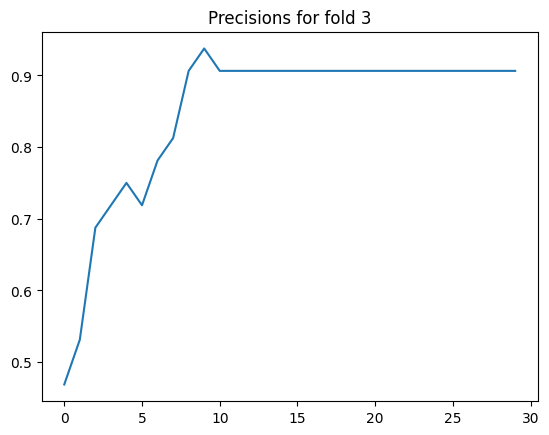

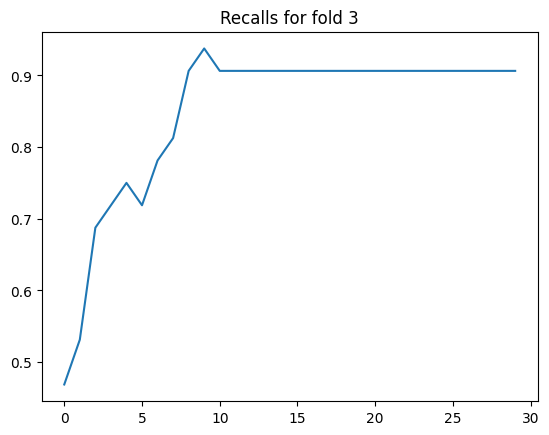

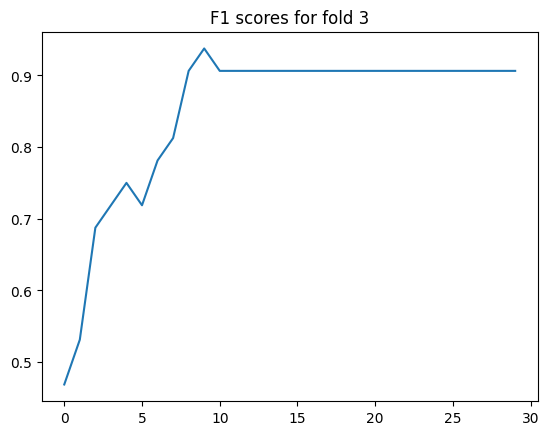

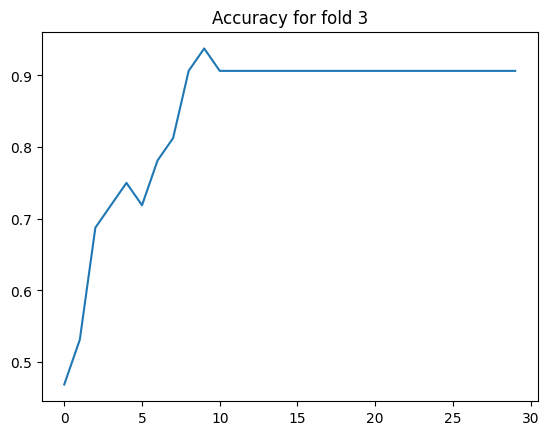

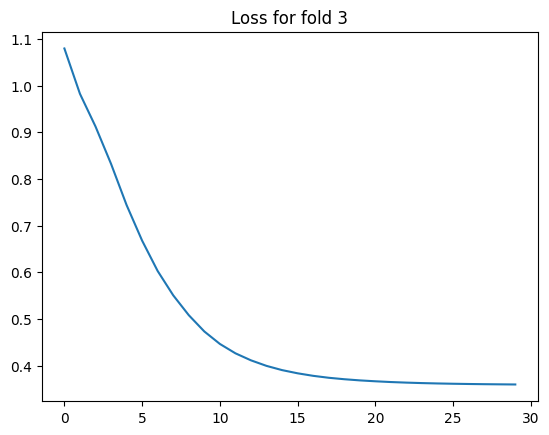

Fold 4, epoch count: 29
Accuracy: 0.8125
Precision: 0.8125
Recall: 0.8125
F1 Score: 0.8125
Confusion matrix: [[ 6.  1.  0.]
 [ 2.  9.  0.]
 [ 2.  1. 11.]]
Loss: 0.46805518865585327


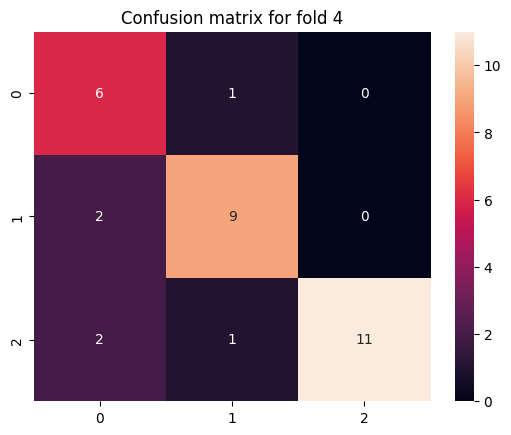

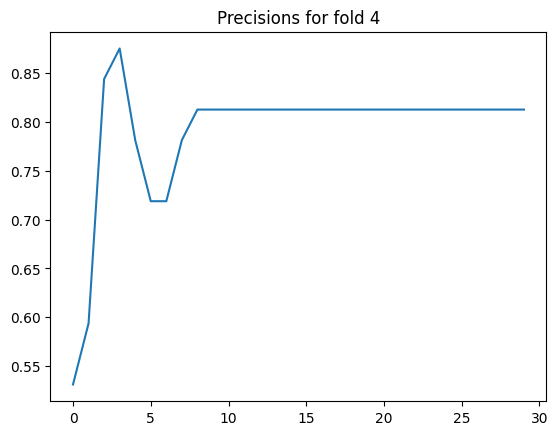

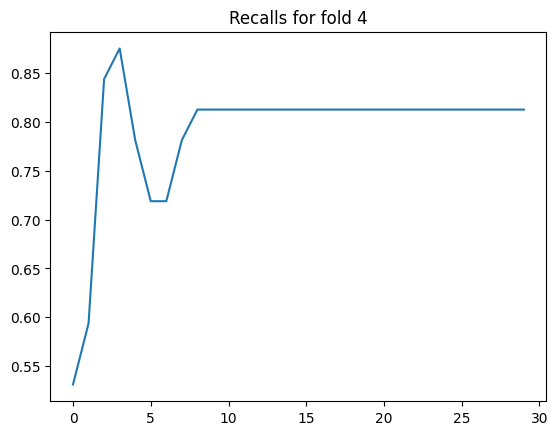

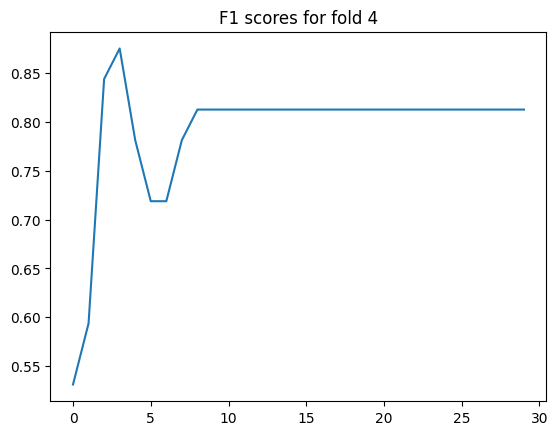

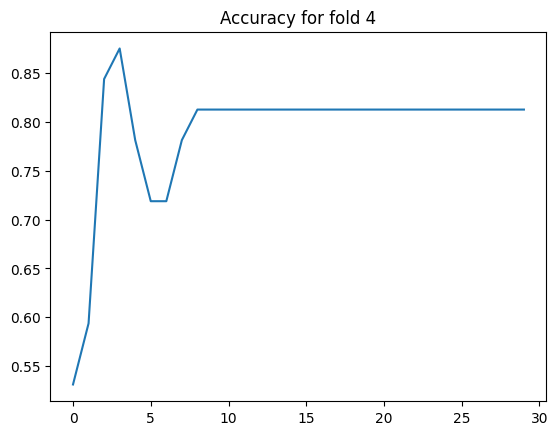

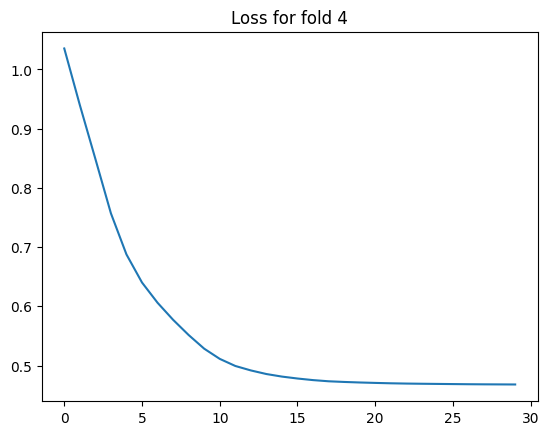

Fold 5, epoch count: 29
Accuracy: 0.90625
Precision: 0.90625
Recall: 0.90625
F1 Score: 0.90625
Confusion matrix: [[ 8.  0.  0.]
 [ 0. 11.  1.]
 [ 2.  0. 10.]]
Loss: 0.28619879484176636


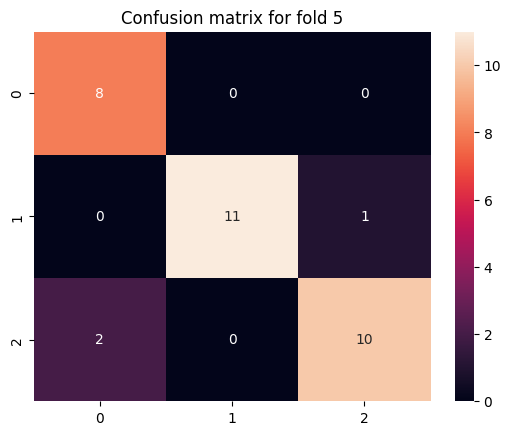

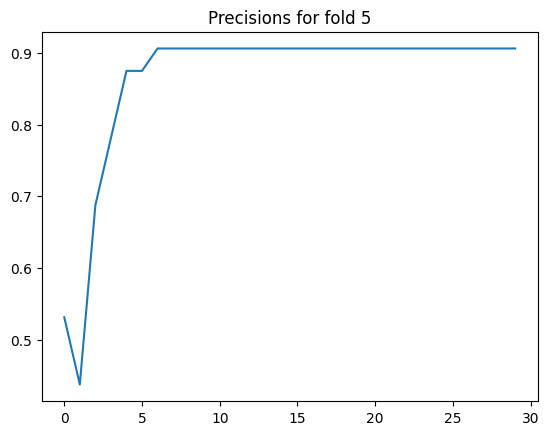

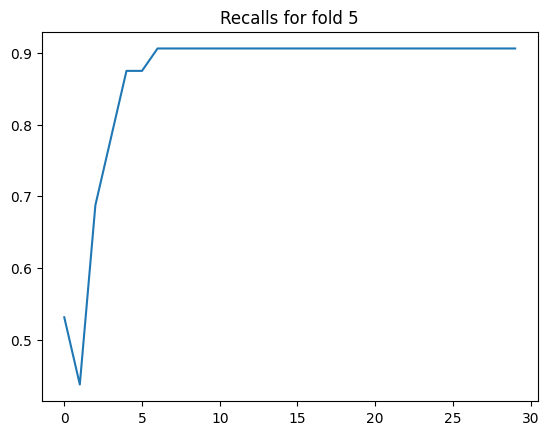

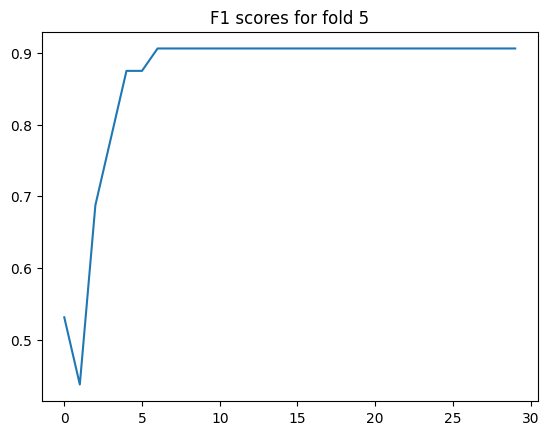

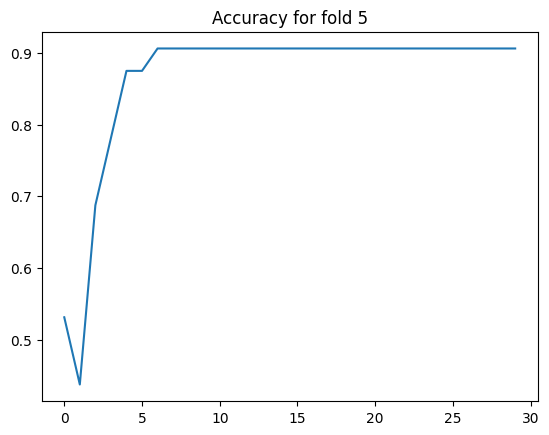

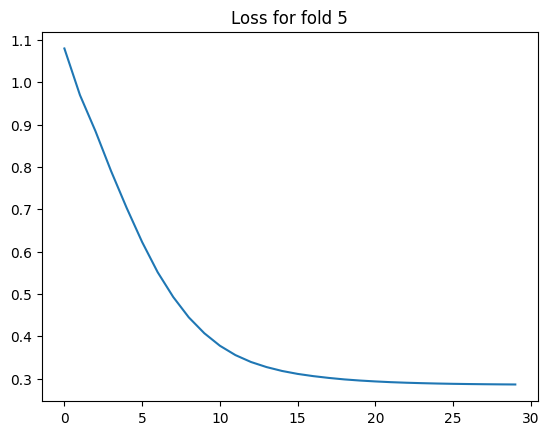

Finished Training, took 24m 1s
Average accuracy: 0.890625
Average precision: 0.890625
Average recall: 0.890625
Average F1 score: 0.890625


In [ ]:
if True:    
    folds = 6
    epochs = 30
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device)
    #vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    vgg16 = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
    # vgg16.load_state_dict(torch.load('vgg16.pth'))
    # reset the last layer
    # Freeze training for all layers
    for param in vgg16.features.parameters():
      param.require_grad = False

    in_features = vgg16.classifier[-1].in_features
    classifier = list(vgg16.classifier.children())[:-1]
    classifier.extend([nn.Linear(in_features, 3)])
    vgg16.classifier = nn.Sequential(*classifier)
    print(vgg16.classifier)
    vgg16 = vgg16.to(device)
    if torch.cuda.is_available():
        vgg16.cuda()
    dataset = HockeyDataset(
        'cs484/dataset', models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(antialias=True))
    # kfold = KFold(n_splits=fold, shuffle=True)
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=3)

 #   train_size = int(0.8 * len(dataset))
 #   test_size = len(dataset) - train_size
 #   train, test = random_split(dataset, [train_size, test_size])

    begin = time.time()
    initial_weight = copy.deepcopy(vgg16.state_dict())
    accuracy = []
    best_epochs = []
    pr = []
    re = []
    ff1 = []
    precision = MulticlassPrecision(num_classes=3, device=device)
    recall = MulticlassRecall(num_classes=3, device=device)
    f1 = MulticlassF1Score(num_classes=3, device=device)
    cm = MulticlassConfusionMatrix(3, device=device)
    acc = MulticlassAccuracy(num_classes=3, device=device)
    for (fold, (train, test)) in enumerate(kfold.split(dataset, np.full(64, 0).tolist() + np.full(64, 1).tolist() + np.full(64, 2).tolist())):
        #print("Train: ", train, "Validation: ", test)
        trainloader = DataLoader(dataset, batch_size=32, sampler=train, num_workers=2)
        valloader = DataLoader(dataset, batch_size=32, sampler=test, num_workers=2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)
        #optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(
               optimizer, step_size=5, gamma=0.80)

        vgg16.load_state_dict(initial_weight)
        #best_weight = copy.deepcopy(initial_weight)
        best_acc = 0.0
        best_epoch = 0
        best_precision = None
        best_recall = None
        best_f1 = None
        best_cm = None
        best_torch_acc = None
        fold_precisions = np.empty(shape=epochs)
        fold_recalls = np.empty(shape=epochs)
        fold_f1s = np.empty(shape=epochs)
        fold_accs = np.empty(shape=epochs)
        fold_losses = np.empty(shape=epochs)

        for epoch in range(epochs):
            # Training phase
            vgg16.train()
            running_loss = 0.0
            running_corrects = 0
            correct_labels = []
            guessed_labels = []
            for inputs, labels in trainloader:
                labels = labels.type(torch.LongTensor)
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                optimizer.zero_grad()
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                #print(type(labels))
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                scheduler.step()

                del inputs, outputs, labels, preds

            epoch_loss = running_loss / len(train)
            epoch_acc = running_corrects.double() / len(train)
            #print('Epoch: {} train Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))
            running_loss = 0.0
            running_corrects = 0
            vgg16.eval()
            with torch.no_grad():
                for images, labels in valloader:
                    labels = labels.type(torch.LongTensor)
                    optimizer.zero_grad()
                    #images = images.to(device)
                    #labels = labels.to(device)

                    if torch.cuda.is_available():
                      images, labels = Variable(images.cuda()), Variable(labels.cuda())
                    else:
                      images, labels = Variable(images), Variable(labels)
                    outputs = vgg16(images)
                    _, predicted = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                    precision.update(labels, predicted)
                    recall.update(labels, predicted)
                    f1.update(labels, predicted)
                    cm.update(labels, predicted)
                    acc.update(labels, predicted)
                    
                    del images, labels, outputs, predicted
            
            epoch_loss = running_loss / len(test)
            epoch_acc = running_corrects.double() / len(test)
            best_precision = precision.compute().to(torch.device("cpu")).item()
            best_recall = recall.compute().to(torch.device("cpu")).item()
            best_f1 = f1.compute().to(torch.device("cpu")).item()
            best_torch_acc = acc.compute().to(torch.device("cpu")).item()
            fold_precisions[epoch] = best_precision
            fold_recalls[epoch] = best_recall
            fold_f1s[epoch] = best_f1
            fold_accs[epoch] = best_torch_acc
            fold_losses[epoch] = epoch_loss
            #print('Epoch: {} eval Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

            if epoch == epochs - 1:
                best_acc = epoch_acc
                #best_weight = copy.deepcopy(vgg16.state_dict())
                best_epoch = epoch
                best_cm = cm.compute().to(torch.device("cpu")).numpy()
                print(f"Fold {fold}, epoch count: {epoch}")
                print(f"Accuracy: {best_torch_acc}")
                print(f"Precision: {best_precision}")
                print(f"Recall: {best_recall}")
                print(f"F1 Score: {best_f1}")
                print(f"Confusion matrix: {best_cm}")
                print(f"Loss: {epoch_loss}")

                ax = plt.subplot()
                sn.heatmap(best_cm, annot=True)
                plt.title(f"Confusion matrix for fold {fold}")
                plt.show()

                ax = plt.subplot()
                plt.plot(range(epochs), fold_precisions)
                plt.title(f"Precisions for fold {fold}")
                plt.show()

                ax = plt.subplot()
                plt.plot(range(epochs), fold_recalls)
                plt.title(f"Recalls for fold {fold}")
                plt.show()

                ax = plt.subplot()
                plt.plot(range(epochs), fold_f1s)
                plt.title(f"F1 scores for fold {fold}")
                plt.show()

                ax = plt.subplot()
                plt.plot(range(epochs), fold_accs)
                plt.title(f"Accuracy for fold {fold}")
                plt.show()

                ax = plt.subplot()
                plt.plot(range(epochs), fold_losses)
                plt.title(f"Loss for fold {fold}")
                plt.show()        

            precision.reset()
            recall.reset()
            f1.reset()
            cm.reset()
            acc.reset()

        accuracy.append(best_torch_acc)
        pr.append(best_precision)
        re.append(best_recall)
        ff1.append(best_f1)
        best_epochs.append(best_epoch)
        #print(f"Fold {fold} accuracy: {best_acc} achieved in epoch {best_epoch}")
        #torch.save(best_weight, f"vgg16_fold{fold}.pth")


    time_elapsed = time.time() - begin
    print(f"Finished Training, took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Average accuracy: {sum(accuracy) / len(accuracy)}")
    print(f"Average precision: {sum(pr) / len(pr)}")
    print(f"Average recall: {sum(re) / len(re)}")
    print(f"Average F1 score: {sum(ff1) / len(ff1)}")
    #print(f"Average epoch: {sum(best_epochs) / len(best_epochs)}")
    '''
    print(f"Precision: {precision.compute()}")
    print(f"Recall: {recall.compute()}")
    print(f"F1 Score: {f1.compute()}")
    print(f"Confusion matrix: {cm.compute()}")
    print(f"Accuracy (pytorch): {acc.compute()}")'''

avg. accuracies (step size 7, gamma 0.1)
- 50 epochs, batch size 32, lr 0.001 : 0.4
- 50 epochs, batch size 32, lr 0.0005: 0.4
- 50 epochs, batch size 16, lr 0.001: 0.38
- VGG16_bn, 50 epochs, batch size 32, lr: 0.001: 0.43
- VGG16_bn, 50 epochs, batch size 32, lr: 0.004: 0.39

avg. accuracies (step size 10, gamma 0.05)
- VGG16_bn, 50 epochs, batch size 32, lr: 0.001: 0.56
- VGG16_bn, 100 epochs, batch size 32, lr: 0.001, step size: 15, gamma: 0.05: 0.49
- VGG16_bn, 50 epochs, batch size 32, lr: 0.001, no LR scheduler: 0.78
- VGG16_bn, 50 epochs, batch size 40, lr: 0.001, no LR scheduler [note: overfitting after epoch 26]: 0.807
- VGG16_bn, 50 epochs, batch size 40, lr: 0.001, step size: 25, gamma: 0.05: 0.67
- VGG16_bn, 50 epochs, batch size 40, lr: 0.001, step size: 25, gamma: 0.90: 0.807
- VGG16_bn, 50 epochs, batch size 40, lr: 0.001, step size: 25, gamma: 0.95: 0.807
- VGG16_bn, 50 epochs, batch size 40, lr: 0.002, step size: 25, gamma: 0.85: ???
- **VGG16_bn, 100 epochs, batch size 40, lr: 0.001, step size: 25, gamma: 0.95: 0.848**
- VGG16_bn, 50 epochs, batch size 40, lr: 0.001, step size: 25, gamma: 0.85: 0.76


VGG16_bn, 100 epochs, batch size 40: lr, 0.001, step size 25, gamma 0.95:
```
Finished Training, took 78m 41s
Average accuracy: 0.7760416666666666
Average epoch: 17.666666666666668
Precision: tensor([0.5452, 0.5323, 0.6661], device='cuda:0')
Recall: tensor([0.4966, 0.5398, 0.7272], device='cuda:0')
F1 Score: tensor([0.5197, 0.5360, 0.6953], device='cuda:0')
Confusion matrix: tensor([[3489., 2193., 1344.],
        [2112., 3407.,  793.],
        [ 799.,  800., 4263.]], device='cuda:0')
```

VGG16_bn, 50 epochs, batch size 40, lr: 0.001, step size 25, gamma 0.95
```
Finished Training, took 39m 39s
Average accuracy: 0.8020833333333333
Average epoch: 15.333333333333334
Precision: tensor([0.5306, 0.6575, 0.8512], device='cuda:0')
Recall: tensor([0.6084, 0.6296, 0.7857], device='cuda:0')
F1 Score: tensor([0.5669, 0.6432, 0.8172], device='cuda:0')
Confusion matrix: tensor([[1698.,  854.,  239.],
        [1001., 2104.,  237.],
        [ 501.,  242., 2724.]], device='cuda:0')
Accuracy (pytorch): 0.6797916889190674
```

VGG16_bn, 100 epochs, batch size 40, lr: 0.0001, step size 5, gamma 0.95
```
Fold 0, epoch count: 49
Best epoch so far: 14
Accuracy: 0.9375
Precision: tensor([1.0000, 0.8182, 1.0000])
Recall: tensor([1.0000, 1.0000, 0.8333])
F1 Score: tensor([1.0000, 0.9000, 0.9091])
Confusion matrix: tensor([[11.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 0.,  2., 10.]])
Fold 0, epoch count: 99
Best epoch so far: 14
Accuracy: 0.9375
Precision: tensor([1.0000, 0.8182, 1.0000])
Recall: tensor([1.0000, 1.0000, 0.8333])
F1 Score: tensor([1.0000, 0.9000, 0.9091])
Confusion matrix: tensor([[11.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 0.,  2., 10.]])
Fold 0 accuracy: 0.9375 achieved in epoch 14
Train:  [  0   1   2   3   4   5   6   7   8  10  12  13  14  15  16  18  19  20
  21  22  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  42
  44  45  46  48  49  50  51  52  53  54  57  58  59  60  61  62  63  64
  66  67  68  69  70  71  73  74  75  76  77  79  80  81  82  83  84  85
  86  87  89  90  91  93  94  95  97  98  99 100 101 102 104 105 106 107
 108 109 110 111 112 113 114 115 117 118 121 122 123 124 126 127 128 129
 130 131 132 134 135 136 137 138 139 140 142 143 144 145 146 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170
 171 173 174 175 176 177 178 179 180 184 185 186 187 188 189 190] Validation:  [  9  11  17  23  24  26  41  43  47  55  56  65  72  78  88  92  96 103
 116 119 120 125 133 141 147 148 169 172 181 182 183 191]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 1, epoch count: 49
Best epoch so far: 8
Accuracy: 0.96875
Precision: tensor([0.9091, 1.0000, 1.0000])
Recall: tensor([1.0000, 0.9167, 1.0000])
F1 Score: tensor([0.9524, 0.9565, 1.0000])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 1., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 1, epoch count: 99
Best epoch so far: 8
Accuracy: 0.96875
Precision: tensor([0.9091, 1.0000, 1.0000])
Recall: tensor([1.0000, 0.9167, 1.0000])
F1 Score: tensor([0.9524, 0.9565, 1.0000])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 1., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 1 accuracy: 0.96875 achieved in epoch 8
Train:  [  0   1   2   3   4   7   9  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  28  30  31  32  33  34  35  36  37  38  40  41  43
  44  46  47  49  50  51  52  53  54  55  56  57  58  59  60  61  63  64
  65  66  67  68  70  71  72  73  75  76  77  78  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101 103 104 105
 106 107 109 111 112 113 115 116 118 119 120 121 122 123 124 125 127 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 151 152 154 155 158 159 160 162 163 164 165 166 168 169 170 171
 172 173 174 175 176 177 179 180 181 182 183 185 187 188 189 191] Validation:  [  5   6   8  10  27  29  39  42  45  48  62  69  74  79  98 102 108 110
 114 117 126 128 150 153 156 157 161 167 178 184 186 190]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 2, epoch count: 49
Best epoch so far: 7
Accuracy: 0.9375
Precision: tensor([0.8182, 1.0000, 1.0000])
Recall: tensor([1.0000, 0.9091, 0.9167])
F1 Score: tensor([0.9000, 0.9524, 0.9565])
Confusion matrix: tensor([[ 9.,  0.,  0.],
        [ 1., 10.,  0.],
        [ 1.,  0., 11.]])
Fold 2, epoch count: 99
Best epoch so far: 7
Accuracy: 0.9375
Precision: tensor([0.8182, 1.0000, 1.0000])
Recall: tensor([1.0000, 0.9091, 0.9167])
F1 Score: tensor([0.9000, 0.9524, 0.9565])
Confusion matrix: tensor([[ 9.,  0.,  0.],
        [ 1., 10.,  0.],
        [ 1.,  0., 11.]])
Fold 2 accuracy: 0.9375 achieved in epoch 7
Train:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  26  27  28  29  30  31  32  34  36  37  38  39  40  41
  42  43  45  46  47  48  50  51  54  55  56  57  58  59  60  61  62  65
  66  67  68  69  70  71  72  73  74  75  76  78  79  81  82  83  84  85
  86  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 108 110 111 113 114 116 117 118 119 120 121 122 124 125 126 128
 129 130 131 132 133 134 135 137 138 141 142 143 144 145 146 147 148 149
 150 151 153 156 157 158 160 161 162 163 164 165 166 167 168 169 171 172
 173 176 177 178 179 181 182 183 184 185 186 187 188 189 190 191] Validation:  [  7  15  22  25  33  35  44  49  52  53  63  64  77  80  87 107 109 112
 115 123 127 136 139 140 152 154 155 159 170 174 175 180]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 3, epoch count: 49
Best epoch so far: 10
Accuracy: 0.9375
Precision: tensor([0.9091, 0.9000, 1.0000])
Recall: tensor([1.0000, 1.0000, 0.8462])
F1 Score: tensor([0.9524, 0.9474, 0.9167])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 1.,  1., 11.]])
Fold 3, epoch count: 99
Best epoch so far: 10
Accuracy: 0.9375
Precision: tensor([0.9091, 0.9000, 1.0000])
Recall: tensor([1.0000, 1.0000, 0.8462])
F1 Score: tensor([0.9524, 0.9474, 0.9167])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 0.,  9.,  0.],
        [ 1.,  1., 11.]])
Fold 3 accuracy: 0.9375 achieved in epoch 10
Train:  [  0   1   3   5   6   7   8   9  10  11  12  14  15  16  17  18  22  23
  24  25  26  27  28  29  30  33  34  35  36  38  39  40  41  42  43  44
  45  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  77  78  79  80  82  83  84
  85  87  88  91  92  93  94  96  97  98 100 101 102 103 104 106 107 108
 109 110 111 112 114 115 116 117 118 119 120 122 123 124 125 126 127 128
 129 130 131 133 134 136 137 138 139 140 141 142 144 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 161 163 165 167 168 169 170 172 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 189 190 191] Validation:  [  2   4  13  19  20  21  31  32  37  46  75  76  81  86  89  90  95  99
 105 113 121 132 135 143 145 160 162 164 166 171 173 188]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 4, epoch count: 49
Best epoch so far: 7
Accuracy: 0.9375
Precision: tensor([0.9000, 0.9091, 1.0000])
Recall: tensor([0.9000, 1.0000, 0.9167])
F1 Score: tensor([0.9000, 0.9524, 0.9565])
Confusion matrix: tensor([[ 9.,  1.,  0.],
        [ 0., 10.,  0.],
        [ 1.,  0., 11.]])
Fold 4, epoch count: 99
Best epoch so far: 7
Accuracy: 0.9375
Precision: tensor([0.9000, 0.9091, 1.0000])
Recall: tensor([0.9000, 1.0000, 0.9167])
F1 Score: tensor([0.9000, 0.9524, 0.9565])
Confusion matrix: tensor([[ 9.,  1.,  0.],
        [ 0., 10.,  0.],
        [ 1.,  0., 11.]])
Fold 4 accuracy: 0.9375 achieved in epoch 7
Train:  [  0   2   4   5   6   7   8   9  10  11  13  14  15  16  17  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  41
  42  43  44  45  46  47  48  49  52  53  54  55  56  57  58  60  62  63
  64  65  66  68  69  70  72  73  74  75  76  77  78  79  80  81  82  83
  85  86  87  88  89  90  91  92  95  96  98  99 100 102 103 105 106 107
 108 109 110 111 112 113 114 115 116 117 119 120 121 123 125 126 127 128
 129 130 132 133 134 135 136 139 140 141 142 143 145 147 148 150 151 152
 153 154 155 156 157 158 159 160 161 162 164 166 167 168 169 170 171 172
 173 174 175 177 178 179 180 181 182 183 184 186 187 188 190 191] Validation:  [  1   3  12  18  30  40  50  51  59  61  67  71  84  93  94  97 101 104
 118 122 124 131 137 138 144 146 149 163 165 176 185 189]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 5, epoch count: 49
Best epoch so far: 10
Accuracy: 0.96875
Precision: tensor([1.0000, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 1.0000])
F1 Score: tensor([0.9524, 1.0000, 0.9524])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 5, epoch count: 99
Best epoch so far: 10
Accuracy: 0.96875
Precision: tensor([1.0000, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 1.0000])
F1 Score: tensor([0.9524, 1.0000, 0.9524])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 5 accuracy: 0.96875 achieved in epoch 10
Finished Training, took 88m 23s
Average accuracy: 0.9479166666666666
Average epoch: 9.333333333333334

```

VGG16_bn, 100 epochs, batch size 32, lr: 0.0001, step size 5, gamma 0.95
```
Fold 0, epoch count: 49
Best epoch so far: 6
Accuracy: 0.90625
Precision: tensor([0.9091, 0.8182, 1.0000])
Recall: tensor([1.0000, 0.9000, 0.8333])
F1 Score: tensor([0.9524, 0.8571, 0.9091])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 1.,  9.,  0.],
        [ 0.,  2., 10.]])
Fold 0, epoch count: 99
Best epoch so far: 6
Accuracy: 0.90625
Precision: tensor([0.9091, 0.8182, 1.0000])
Recall: tensor([1.0000, 0.9000, 0.8333])
F1 Score: tensor([0.9524, 0.8571, 0.9091])
Confusion matrix: tensor([[10.,  0.,  0.],
        [ 1.,  9.,  0.],
        [ 0.,  2., 10.]])
Fold 0 accuracy: 0.90625 achieved in epoch 6
Train:  [  0   1   2   3   4   5   6   7   8  10  12  13  14  15  16  18  19  20
  21  22  25  27  28  29  30  31  32  33  34  35  36  37  38  39  40  42
  44  45  46  48  49  50  51  52  53  54  57  58  59  60  61  62  63  64
  66  67  68  69  70  71  73  74  75  76  77  79  80  81  82  83  84  85
  86  87  89  90  91  93  94  95  97  98  99 100 101 102 104 105 106 107
 108 109 110 111 112 113 114 115 117 118 121 122 123 124 126 127 128 129
 130 131 132 134 135 136 137 138 139 140 142 143 144 145 146 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170
 171 173 174 175 176 177 178 179 180 184 185 186 187 188 189 190] Validation:  [  9  11  17  23  24  26  41  43  47  55  56  65  72  78  88  92  96 103
 116 119 120 125 133 141 147 148 169 172 181 182 183 191]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
WARNING:root:One or more NaNs identified, as no ground-truth instances of [0] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 1, epoch count: 49
Best epoch so far: 6
Accuracy: 0.9375
Precision: tensor([0.9091, 0.9091, 1.0000])
Recall: tensor([0.9091, 0.9091, 1.0000])
F1 Score: tensor([0.9091, 0.9091, 1.0000])
Confusion matrix: tensor([[10.,  1.,  0.],
        [ 1., 10.,  0.],
        [ 0.,  0., 10.]])
Fold 1, epoch count: 99
Best epoch so far: 6
Accuracy: 0.9375
Precision: tensor([0.9091, 0.9091, 1.0000])
Recall: tensor([0.9091, 0.9091, 1.0000])
F1 Score: tensor([0.9091, 0.9091, 1.0000])
Confusion matrix: tensor([[10.,  1.,  0.],
        [ 1., 10.,  0.],
        [ 0.,  0., 10.]])
Fold 1 accuracy: 0.9375 achieved in epoch 6
Train:  [  0   1   2   3   4   7   9  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  28  30  31  32  33  34  35  36  37  38  40  41  43
  44  46  47  49  50  51  52  53  54  55  56  57  58  59  60  61  63  64
  65  66  67  68  70  71  72  73  75  76  77  78  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101 103 104 105
 106 107 109 111 112 113 115 116 118 119 120 121 122 123 124 125 127 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 151 152 154 155 158 159 160 162 163 164 165 166 168 169 170 171
 172 173 174 175 176 177 179 180 181 182 183 185 187 188 189 191] Validation:  [  5   6   8  10  27  29  39  42  45  48  62  69  74  79  98 102 108 110
 114 117 126 128 150 153 156 157 161 167 178 184 186 190]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 2, epoch count: 49
Best epoch so far: 7
Accuracy: 0.875
Precision: tensor([0.7273, 0.9000, 1.0000])
Recall: tensor([0.8889, 0.7500, 1.0000])
F1 Score: tensor([0.8000, 0.8182, 1.0000])
Confusion matrix: tensor([[ 8.,  1.,  0.],
        [ 3.,  9.,  0.],
        [ 0.,  0., 11.]])
Fold 2, epoch count: 99
Best epoch so far: 7
Accuracy: 0.875
Precision: tensor([0.7273, 0.9000, 1.0000])
Recall: tensor([0.8889, 0.7500, 1.0000])
F1 Score: tensor([0.8000, 0.8182, 1.0000])
Confusion matrix: tensor([[ 8.,  1.,  0.],
        [ 3.,  9.,  0.],
        [ 0.,  0., 11.]])
Fold 2 accuracy: 0.875 achieved in epoch 7
Train:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  26  27  28  29  30  31  32  34  36  37  38  39  40  41
  42  43  45  46  47  48  50  51  54  55  56  57  58  59  60  61  62  65
  66  67  68  69  70  71  72  73  74  75  76  78  79  81  82  83  84  85
  86  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 108 110 111 113 114 116 117 118 119 120 121 122 124 125 126 128
 129 130 131 132 133 134 135 137 138 141 142 143 144 145 146 147 148 149
 150 151 153 156 157 158 160 161 162 163 164 165 166 167 168 169 171 172
 173 176 177 178 179 181 182 183 184 185 186 187 188 189 190 191] Validation:  [  7  15  22  25  33  35  44  49  52  53  63  64  77  80  87 107 109 112
 115 123 127 136 139 140 152 154 155 159 170 174 175 180]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 3, epoch count: 49
Best epoch so far: 9
Accuracy: 0.9375
Precision: tensor([0.9091, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 0.9091])
F1 Score: tensor([0.9091, 1.0000, 0.9091])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 10.,  0.],
        [ 1.,  0., 10.]])
Fold 3, epoch count: 99
Best epoch so far: 9
Accuracy: 0.9375
Precision: tensor([0.9091, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 0.9091])
F1 Score: tensor([0.9091, 1.0000, 0.9091])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 10.,  0.],
        [ 1.,  0., 10.]])
Fold 3 accuracy: 0.9375 achieved in epoch 9
Train:  [  0   1   3   5   6   7   8   9  10  11  12  14  15  16  17  18  22  23
  24  25  26  27  28  29  30  33  34  35  36  38  39  40  41  42  43  44
  45  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  77  78  79  80  82  83  84
  85  87  88  91  92  93  94  96  97  98 100 101 102 103 104 106 107 108
 109 110 111 112 114 115 116 117 118 119 120 122 123 124 125 126 127 128
 129 130 131 133 134 136 137 138 139 140 141 142 144 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 161 163 165 167 168 169 170 172 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 189 190 191] Validation:  [  2   4  13  19  20  21  31  32  37  46  75  76  81  86  89  90  95  99
 105 113 121 132 135 143 145 160 162 164 166 171 173 188]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 4, epoch count: 49
Best epoch so far: 8
Accuracy: 0.875
Precision: tensor([0.8000, 0.8182, 1.0000])
Recall: tensor([0.8000, 0.9000, 0.9167])
F1 Score: tensor([0.8000, 0.8571, 0.9565])
Confusion matrix: tensor([[ 8.,  2.,  0.],
        [ 1.,  9.,  0.],
        [ 1.,  0., 11.]])
Fold 4, epoch count: 99
Best epoch so far: 8
Accuracy: 0.875
Precision: tensor([0.8000, 0.8182, 1.0000])
Recall: tensor([0.8000, 0.9000, 0.9167])
F1 Score: tensor([0.8000, 0.8571, 0.9565])
Confusion matrix: tensor([[ 8.,  2.,  0.],
        [ 1.,  9.,  0.],
        [ 1.,  0., 11.]])
Fold 4 accuracy: 0.875 achieved in epoch 8
Train:  [  0   2   4   5   6   7   8   9  10  11  13  14  15  16  17  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  41
  42  43  44  45  46  47  48  49  52  53  54  55  56  57  58  60  62  63
  64  65  66  68  69  70  72  73  74  75  76  77  78  79  80  81  82  83
  85  86  87  88  89  90  91  92  95  96  98  99 100 102 103 105 106 107
 108 109 110 111 112 113 114 115 116 117 119 120 121 123 125 126 127 128
 129 130 132 133 134 135 136 139 140 141 142 143 145 147 148 150 151 152
 153 154 155 156 157 158 159 160 161 162 164 166 167 168 169 170 171 172
 173 174 175 177 178 179 180 181 182 183 184 186 187 188 190 191] Validation:  [  1   3  12  18  30  40  50  51  59  61  67  71  84  93  94  97 101 104
 118 122 124 131 137 138 144 146 149 163 165 176 185 189]

WARNING:root:One or more NaNs identified, as no ground-truth instances of [2] have been seen. These have been converted to zero.
WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.

Fold 5, epoch count: 49
Best epoch so far: 8
Accuracy: 0.96875
Precision: tensor([1.0000, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 1.0000])
F1 Score: tensor([0.9524, 1.0000, 0.9524])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 5, epoch count: 99
Best epoch so far: 8
Accuracy: 0.96875
Precision: tensor([1.0000, 1.0000, 0.9091])
Recall: tensor([0.9091, 1.0000, 1.0000])
F1 Score: tensor([0.9524, 1.0000, 0.9524])
Confusion matrix: tensor([[10.,  0.,  1.],
        [ 0., 11.,  0.],
        [ 0.,  0., 10.]])
Fold 5 accuracy: 0.96875 achieved in epoch 8
Finished Training, took 76m 49s
Average accuracy: 0.9166666666666666
Average epoch: 7.333333333333333
```